# Demonstration of basic Web Scraping

Here is the deal: learn in one notebook how to scrape information about your facebook friends (any information from birthday, to post-history) and structure the data! Let's take their current occupation as an example, just to lay out the approach!

Because the desired list of occupations is not provided by facebook for download into a spreadsheet this is an example of unstructured data, and in this case we will **scrape** it from the web. Some websites have API (Application Programming Interface) that allow a user to retrieve structured data, for example directly querying their database. Levels and contraints of access depend on the specific website, and although facebook has an API we want to demonstrate here the skill of scraping data which is often useful in Data Science.

The basic concept is that data can be retrieved from a webpage programmatically by parsing the source-code (e.g. HTML). Since we might want to do this automatically on many pages we need to **access pages programmatically** via their URL and possibly move from page to page by jumping from one URL to the next.

The simplest tool to access URLs in Python is **urllib3** or **requests**, but this methods have the drawback of yielding a different source code than what you would get by actually surfing with your browser. So I will now show you how to use **WebDriver** with **Selenium**, for the other mentioned libraries look at the end of this document.

# 1. Webdriver from the Selenium library

With the Selenium library, I could get the same code that I would obtain by manual browsing. So here is how it works:

In [3]:
from selenium import webdriver  
from selenium.common.exceptions import NoSuchElementException  
from selenium.webdriver.common.keys import Keys  
from bs4 import BeautifulSoup
from selenium.webdriver.chrome.options import Options
import time

_chrome_options = Options()

Here we define the URL that we want to navigate to:

In [3]:
url = "https://www.facebook.com"

And here we define the webdriver, and the browser options that we want during surfing:

In [4]:
# setting this specific options avoids the browser to pop-up requests 
# for saving password and show notifications
pref = {"profile.default_content_setting_values.notifications" : 2, \
       'credentials_enable_service': False, \
        'profile': {'password_manager_enabled': False}}
_chrome_options.add_experimental_option('prefs',pref)

# set up Web Driver with options
driver = webdriver.Chrome(chrome_options=_chrome_options)
driver.get(url)  

Notice that after defining the webdriver we have to go get the URL. This will actually open a browser window and go to the URL.Now we just have to get the page_source and save it in a variable:

In [43]:
html_source = driver.page_source  

A better way to visualize and navigate the source code is to use the BeaufitulSoup library. So we can create an object that we will call *soup* and call the method *prettify()* that will rearrange the code in its readable form:

In [44]:
soup = BeautifulSoup(html_source,'html.parser')
print(soup.prettify()[:200])

<!DOCTYPE html>
<html class="" id="facebook" lang="en" xmlns="http://www.w3.org/1999/xhtml">
 <head>
  <meta charset="utf-8"/>
  <meta content="origin-when-crossorigin" id="meta_referrer" name="referr


In the case of facebook, this code will not open my profile, but will accually navigate to the login page, therefore we will have to instruct the **webdriver** to insert our credentials and then navigate to the pages we want, e.g. my friends list page:

In [ ]:
driver = webdriver.Chrome(chrome_options=_chrome_options) 
driver.get(url)  

# wait for the login elements to load
driver.implicitly_wait(12)

# identify relevant elements
email = driver.find_element_by_css_selector('input[type=email]')
password = driver.find_element_by_css_selector('input[type=password]')
login = driver.find_element_by_css_selector('input[value="Log In"]')

# insert the credentials (you will have to modify this)
email.send_keys('name.lastname@gmail.com') #name.lastname
password.send_keys('your_password!') #your_password

# login
login.click()

# navigate to my friends list (you will have to get the right url for you)
driver.get('https://www.facebook.com/...........a specific URL..........')
#https://www.facebook.com/profile.php?id=.....blabla......._friends_tl

# scroll to bottom of the page several times to load all of them (about 1000 friends)
for i in range(65):
    # wait for the login elements to load
    # driver.implicitly_wait(10)
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)

# take ascreenshot
#driver.get_screenshot_as_file('yourName-profile.png')

# get source-code from current page
html_source = driver.page_source  

# quit browser
#driver.quit()

Again we can visualize the result with BeautifulSoup:

In [94]:
soup = BeautifulSoup(html_source,'html.parser')

#save output to file
with open("Output.txt", "w") as text_file:
    soupp = soup.prettify()
    print(soupp.encode("utf-8"), file=text_file)
    
# show some of the code
print(soupp[:200])

<!DOCTYPE html>
<html class="" id="facebook" lang="it" xmlns="http://www.w3.org/1999/xhtml">
 <head>
  <meta charset="utf-8"/>
  <meta content="origin-when-crossorigin" id="meta_referrer" name="referr


With this tool we can now navigate facebook as we were logged in our account. To go from one page to another we just need to figure out where to find the links. If I want to navigate from my profile to my friends list page, I need to parse the source code and find the URL that corresponds to that link. It is now a matter of finding the logic of where those URLs are located within the page, extract them from the soup with **regex** (Regular Expressions) and use another request to go to that page, get the source code from there, look for information or the next URL, and so on!

Wellcome to the art of Web Scraping!

# Sidenote: Parsing with RegEx

Even if every page has a different code, there are patterns that stay the same. For every project we might want to search for similar information in very similar pages, therefore we can identify those code patterns that contain what we need and scrape it. There is no doubt that we need to learn now how to use RegEx or REGular EXpressions which is an obiquitous tool programming, independently of the language.

Here we will implement this tool in Python to search my friends list for their facebook URL, because we want to first go to their profile, then to their info-page or get info from their walls.

In [8]:
import re

This imports the python regex library, if you are already familiar with this concept you can move own and are ready to do your own scraping now, otherwise stick around and see how exactly we can get the info we want. First we need to make a couple of examples to explain how parsing works.

Let's pretend that we want to find the important dates and people names in the following text:

*DNA was first isolated by Friedrich Miescher in 1869. Its molecular structure was identified by James Watson and Francis Crick from Cold Spring Harbor Laboratory in 1953, whose model-building efforts were guided by X-ray diffraction data acquired by Raymond Gosling, who was a post-graduate student of Rosalind Franklin.*

We want to isolate the numbers and names, here is how we could start doing that:

In [51]:
text = 'DNA was first isolated by Friedrich Miescher in 1869.   \
        Its molecular structure was identified by James Watson  \
        and Francis Crick from Cold Spring Harbor Laboratory in \
        1953, whose model-building efforts were guided by X-ray \
        diffraction data acquired by Raymond Gosling, who was a \
        post-graduate student of Rosalind Franklin.'
dates = re.findall('\d{4}', text)
dates

['1869', '1953']

Here we used the function re.findall(*pattern*, *string*), where we looked for the pattern *\d{4}* in the string contained in *text*. Here we used one of the regex **identifiers** (\d) which identifies digits, followed by the **modifier** ({4}) which specifies how many digits in a row constitutes our pattern. And the result is what we wanted.

If we now wanted to find the names of people we would do:

In [55]:
names = re.findall('[A-Z][a-z]*\s[A-Z][a-z]*\W', text)
names

['Friedrich Miescher ',
 'James Watson ',
 'Francis Crick ',
 'Cold Spring ',
 'Harbor Laboratory ',
 'Raymond Gosling,',
 'Rosalind Franklin.']

The pattern here is more complicated, but can be broken down like this:  
**[A-Z]**   &nbsp;&nbsp; any capital letter followed by  
**[a-z]**   &nbsp;&nbsp;&nbsp; any lower case letter with the modifier  
**\***      &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; as many repetitions (of lower case letters)  
**\s**      &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a space  
**[A-Z][a-z]\***  &nbsp;&nbsp;&nbsp;&nbsp; anther word that starts with a capital letter  
**\W**      &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; followed by any non-character

For a full tutorial on Regex see: https://www.youtube.com/watch?v=sZyAn2TW7GY

Notice that this code successfully avoids counting the capitalized words at the beginning of each frase, but fails in recognizing that **Cold Spring Harbor Laboratory** is not a person name. There are other clever things that can be implemented to clean this list programmatically, but goes beyond the scope of this brief tutorial.

# 2. Scraping for URLs

Now we can proceed at extracting data from the HTML file. So once we have the html of our "friends-list" page, we need to find a pattern in the HTML that is predictable for every entry of the list. Let's look at one such example:

It is pretty easy to notice that in the "friend_list" page every friend entry starts with the tag: **friend_list_item**, and the actual link to their profile appears after the first istance of the tag: **href="**, while their name will be just after the tag **aria-label="**. So now we can search for the strings that follow this tags and in particular for the strings comprised between quotes ("string").

First lets extract the sections of code relative to different friends by scraping the code between the **friend_list_item** tags:

In [11]:
# we saved the result of section 1 in the file Output:
soupp = open('Output.txt', 'r')
friends = re.findall('(?<=friend_list_item)([\s\S]*?)(?=friend_list_item)',soupp.read())
len(friends)

1144

Now we can search within each friend section the string that describe their profile URL and their facebook name, like this:

In [12]:
f_links = []
f_names = []
for each in friends:
    pattern_name = '(?<=aria-label=")[\s\S]*?(?=")'
    names = re.findall(pattern_name, each)
    if names[0] not in f_names:
        f_names.append(names[0])
        pattern = '(?<=href=").*?(?=")'
        links = re.findall(pattern, each)
        if links[0] != '#':
            f_links.append(links[0])
        else:
            f_links.append('NOT FOUND')
    else:
        pass

We can merge this two lists into a more elegant data format called a DataFrame, from the Pandas library well known to DataScientists:

In [29]:
import pandas as pd

links = pd.DataFrame({'name': f_names, 'link_prof': f_links,})
links.sort_values(by = 'name')[:5]

,link_prof,name
226,https://www.facebook.com/aaron.haines.353?fref...,Aaron Haines
1061,https://www.facebook.com/azriel.sarsozo?fref=p...,Abriel Sarsozo
76,https://www.facebook.com/achille.boiano?fref=p...,Achille Boiano
199,https://www.facebook.com/adam.graham.52?fref=p...,Adam Graham
181,https://www.facebook.com/adam.stooke?fref=pb&a...,Adam Stooke


The profile URLs that have not been found correspond to deactivated accounts:

In [24]:
links[links['link_prof']=='NOT FOUND'][2:5]

,link_prof,name
155,NOT FOUND,Luciano Silvestri
249,NOT FOUND,Jessica Bishoff
276,NOT FOUND,Fiorella Davila


# Scraping from a list of WebPages

Now that we have the links to my friends list, we can programmatically navigate to their profile, or to any other related page and scrape information from it. Just as a demonstration we could try and get their occupation. 

First of all we need to figure out how to get that information from one of those pages, and then we can loop that function through all of our friends profile URLs!

Here is one of the links:

In [25]:
links[534:535]

,link_prof,name
534,https://www.facebook.com/alfonso.corrado.3?fre...,Alfonso Corrado


Now let's add some other columns to our dataframe where we can store the link to the info_page, the birthday, and other info like that.

In [51]:
import numpy as np

links['info_link'] = ""
links['birthday']= np.nan
links['f_acname']= ""
links.sort_values(by = 'name')[:3]

,link_prof,name,info_link,birthday,f_acname
226,https://www.facebook.com/aaron.haines.353?fref...,Aaron Haines,,NaN,
1061,https://www.facebook.com/azriel.sarsozo?fref=p...,Abriel Sarsozo,,NaN,
76,https://www.facebook.com/achille.boiano?fref=p...,Achille Boiano,,NaN,


Now we should try and populate those columns one at a time, let's try with the info_link, which is the link to the information page for that account.

In [67]:
driver = webdriver.Chrome(chrome_options=_chrome_options) 

url = "https://www.facebook.com"

driver.get(url)
    
# wait for the elements to load
driver.implicitly_wait(12)
    
# identify relevant elements
email = driver.find_element_by_css_selector('input[type=email]')
password = driver.find_element_by_css_selector('input[type=password]')
login = driver.find_element_by_css_selector('input[value="Log In"]')

# insert the credentials (you will have to modify this)
email.send_keys('name.lastname@gmail.com') #name.lastname
password.send_keys('your_password!') #your_password

# login
login.click()

# Iterate through the links in the DataFrame
for index, row in links.iterrows():
    
    if index > 117 and row['link_prof'] != 'NOT FOUND':
        
        driver.get(row['link_prof'])
        info_source = driver.page_source 
        
        # get link to info-page
        info_pattern = '(?<=data-tab-key="about"\shref=")http.*?(?=")\
                    |(?<=href=")?http\w?://www\.facebook\S*?(?="\sdata-tab-key="about")'
        info_page = re.findall(info_pattern, info_source)
        
        # get account idenfier name
        f_account_name = re.findall('(?<=facebook\.com/).*?(?=/)',info_page[0])
    
        try:
            links.loc[index, 'info_link'] = info_page[0]
        except:
            links.loc[index, 'info_link'] = 'NOT FOUND'
        try:
            links.loc[index, 'f_acname'] = f_account_name[0]
        except:
            links.loc[index, 'f_acname'] = 'NOT FOUND'

Notice that while the Regex to find the right URL is a little complicated, the one to find the account name is easier. In fact, once we find the profile URL:

In [90]:
info_page[0]

'https://www.facebook.com/fujhika.tinoco/about?lst=697975281%3A651339901%3A1497298589'

The name can be estracted from there with this Regex:

In [91]:
f_account_name = re.findall('(?<=facebook\.com/).*?(?=/)',info_page[0])
f_account_name[0]

'fujhika.tinoco'

For cosmetic and utility reasons we want to give a name to the index column:

In [79]:
links.index.name = 'f_ID'

We can also explore if any of the information was not found. And we find out that that happened 44 times on the f_acname:

In [89]:
links[links['f_acname']=='NOT FOUND'].count() 

link_prof    44
name         44
info_link    44
birthday      0
f_acname     44
dtype: int64

This is because in those cases the info_page link has a different format:

In [95]:
links[links['f_acname']=='NOT FOUND'][-1:]

,link_prof,name,info_link,birthday,f_acname
f_ID,,,,,
1062,https://www.facebook.com/profile.php?id=153154...,Sean Taylor,https://www.facebook.com/profile.php?id=153154...,NaN,NOT FOUND


If we are going to keep working on this project at another time, this is a good point to save our DataFrame to a file that we can retrieve once we reopen the Jupyter Notebook:

In [81]:
# save dataFrame to file in working directory
links.to_csv('Links_in_progress')

In [85]:
# retrieve DataFrame from csv file
data = pd.read_csv('Links_in_progress', index_col = 'f_ID')
data[-3:]

,link_prof,name,info_link,birthday,f_acname
f_ID,,,,,
1124,https://www.facebook.com/giuseppe.raia.98?fref...,Giuseppe Raia,https://www.facebook.com/giuseppe.raia.98/abou...,NaN,giuseppe.raia.98
1125,NOT FOUND,Giancarlo Cerulo,NaN,NaN,NaN
1126,https://www.facebook.com/fujhika.tinoco?fref=p...,Fujhika Tinoco,https://www.facebook.com/fujhika.tinoco/about?...,NaN,fujhika.tinoco


# Working with DATE datatypes

Now we will scrape for birthdates, load them in the dataframe in a datatype specific for dates....

In [2]:
import pandas as pd

# retrieve DataFrame from csv file
data = pd.read_csv('Links_in_progress', index_col = 'f_ID')
data[-3:]

,link_prof,name,info_link,birthday,f_acname
f_ID,,,,,
1124,https://www.facebook.com/giuseppe.raia.98?fref...,Giuseppe Raia,https://www.facebook.com/giuseppe.raia.98/abou...,NaN,giuseppe.raia.98
1125,NOT FOUND,Giancarlo Cerulo,NaN,NaN,NaN
1126,https://www.facebook.com/fujhika.tinoco?fref=p...,Fujhika Tinoco,https://www.facebook.com/fujhika.tinoco/about?...,NaN,fujhika.tinoco


In [5]:
data['info_link'][0][:4]

'http'

In [57]:
driver = webdriver.Chrome(chrome_options=_chrome_options) 

url = "https://www.facebook.com"

driver.get(url)
    
# wait for the elements to load
driver.implicitly_wait(12)
    
# identify relevant elements
email = driver.find_element_by_css_selector('input[type=email]')
password = driver.find_element_by_css_selector('input[type=password]')
login = driver.find_element_by_css_selector('input[value="Log In"]')

# insert the credentials (you will have to modify this)
email.send_keys('name.lastname@gmail.com') #name.lastname
password.send_keys('your_password!') #your_password

# login
login.click()
    
for index, row in data.iterrows():
    
    if index > 115 and row['info_link'] != 'NOT FOUND' and not pd.isnull(row['info_link']):
        
        driver.get(row['info_link'])
        info_source = driver.page_source 
        pattern = '(?<=di\snascita</span></div><div>)\d{1,2}\s[A-Za-z]{3,10}.*?(?=<)'
        nascita = re.findall(pattern, info_source)
        
        try:
            data.loc[index, 'birthday'] = nascita[0]
        except:
            data.loc[index, 'birthday'] = 'NOT FOUND'        

In [60]:
# save dataFrame to file in working directory
data.to_csv('birthdate_in_progress')

Now we have all the dates in the DataFrame:

In [63]:
data[-3:]

,link_prof,name,info_link,birthday,f_acname
f_ID,,,,,
1124,https://www.facebook.com/giuseppe.raia.98?fref...,Giuseppe Raia,https://www.facebook.com/giuseppe.raia.98/abou...,29 luglio 1985,giuseppe.raia.98
1125,NOT FOUND,Giancarlo Cerulo,NaN,NaN,NaN
1126,https://www.facebook.com/fujhika.tinoco?fref=p...,Fujhika Tinoco,https://www.facebook.com/fujhika.tinoco/about?...,21 settembre,fujhika.tinoco


The dates are in string format. We can change that to be in a different datatype:

In [4]:
from datetime import date, timedelta
import datetime as dt
import locale

# since we are getting the dates in Italian, we have to set the Locale
locale.setlocale(locale.LC_TIME, "italian-swiss")

'Italian_Switzerland.1252'

In [7]:
# Transform dates into datetime objects
for index, row in data.iterrows():
    try:
        date = dt.datetime.strptime(row['birthday'], '%d %B %Y')
        data.loc[index, 'birthday'] = date
    except:
        try:
            # if the year is not present (default will be 1900)
            date = dt.datetime.strptime(row['birthday'], '%d %B')
            data.loc[index, 'birthday'] = date
        except:
            pass

The previous code successfully replaces the birthday string with a datetime datatype. And here are some examples:

In [16]:
data[-3:]

,link_prof,name,info_link,birthday,f_acname
f_ID,,,,,
1124,https://www.facebook.com/giuseppe.raia.98?fref...,Giuseppe Raia,https://www.facebook.com/giuseppe.raia.98/abou...,1985-07-29 00:00:00,giuseppe.raia.98
1125,NOT FOUND,Giancarlo Cerulo,NaN,NaN,NaN
1126,https://www.facebook.com/fujhika.tinoco?fref=p...,Fujhika Tinoco,https://www.facebook.com/fujhika.tinoco/about?...,1900-09-21 00:00:00,fujhika.tinoco


Notice that for people where the year was not present, the default year 1900 was placed. We can check how many friends actually don't have a birthday, either because the account doesn't exist or because the birthday was not available:

In [18]:
data.loc[data['birthday'].apply(lambda x: type(x)!= dt.datetime)].count()

link_prof    250
name         250
info_link    197
birthday     197
f_acname     197
dtype: int64

In [187]:
# save dataFrame to file in working directory
data.to_csv('birthdate_df')

In [2]:
import pandas as pd
# retrieve DataFrame from csv file
data = pd.read_csv('birthdate_df', index_col = 'f_ID')

When we save the file the datatype might be lost so we will have to re-parse the column, the good thing is that now its all in the same format:

In [17]:
# Transform dates into datetime objects
for index, row in data.iterrows():
    try:
        date = dt.datetime.strptime(row['birthday'], '%Y-%m-%d %H:%M:%S')
        data.loc[index, 'birthday'] = date
    except:
        pass

# Some Birthday Analytics

Now that we have a somewhat interesting dataset, we can try and look at some simple statistics about our friends. For example we can plot the distribution of our friends birthdays during the year.

First we need to make a dataframe copy that only contains the actual datetime types:

In [19]:
data2 = data[['birthday']].copy()
data2 = data2.loc[data2['birthday'].apply(lambda x: type(x)== dt.datetime)]
print(len(data2))

877


In [20]:
data[-3:]

,link_prof,name,info_link,birthday,f_acname
f_ID,,,,,
1124,https://www.facebook.com/giuseppe.raia.98?fref...,Giuseppe Raia,https://www.facebook.com/giuseppe.raia.98/abou...,1985-07-29 00:00:00,giuseppe.raia.98
1125,NOT FOUND,Giancarlo Cerulo,NaN,NaN,NaN
1126,https://www.facebook.com/fujhika.tinoco?fref=p...,Fujhika Tinoco,https://www.facebook.com/fujhika.tinoco/about?...,1900-09-21 00:00:00,fujhika.tinoco


The Dataframe will look like this:

In [21]:
data2[-3:]

,birthday
f_ID,
1123,1981-01-31 00:00:00
1124,1985-07-29 00:00:00
1126,1900-09-21 00:00:00


Now we can bin the data by month and plot the histogram:

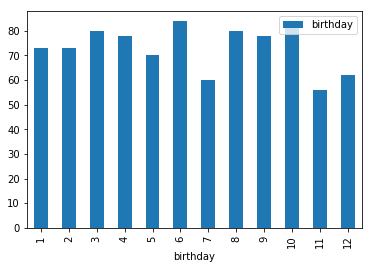

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
data2.groupby(data2['birthday'].dt.month).count().plot(kind="bar")

Or we can bin by week and get a fine-grained graph:

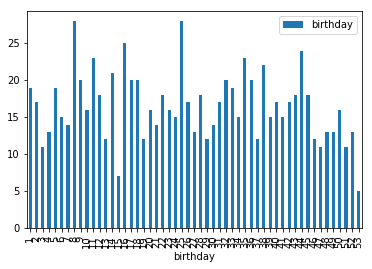

In [23]:
plt.figure(figsize=(14,6))
kw = lambda x: x.isocalendar()[1]
data2.groupby(data2['birthday'].map(kw)).count().plot(kind = 'bar')

If we want to do some data manipulation, extract this histogram data to another data frame:

In [24]:
byweek = data2.groupby(data2['birthday'].map(kw)).count()

We can add a column that contains the averaged counts, and another that has the weeks shifted back by the length of a pregnancy which is 39 weeks:

In [38]:
byweek['smoothed'] = (byweek['birthday'] + \
                      byweek['birthday'].shift(-1) + \
                      byweek['birthday'].shift(-1))/3
byweek['conception'] = byweek.index - 36
byweek['conception'][:35] = byweek['conception'][:35] + 52
byweek = byweek[byweek.index != 53]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


It would be nice at this point to reorder the dataset so that will start at week = 0 in the 'conception' column:

In [54]:
byweek1 = byweek[byweek['conception']>16]
byweek2 = byweek[byweek['conception']<17]
byweek3=pd.concat([byweek2,byweek1], axis=0, join='outer', join_axes=None, ignore_index=False)
byweek3[:3]

,birthday,smoothed,conception
birthday,,,
36,20,14.666667,0
37,12,18.666667,1
38,22,17.333333,2


And we can plot now the smoothed data vs conception week, with its average value for comparison:

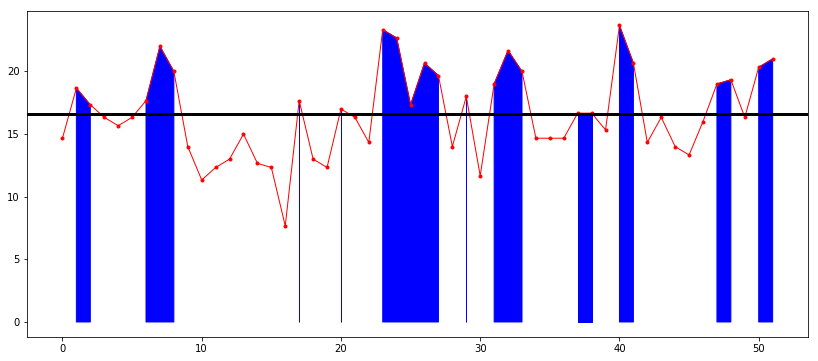

In [91]:
import numpy as np
plt.figure(figsize=(14,6))

x = byweek3['conception']
y= byweek3['smoothed']
plt.plot(x, y, marker='.', color='red', lw=1 )
d = np.zeros(53)
d1 = np.ones(52)*16.5
plt.fill_between(x, y, where=y>=d1, interpolate=False, color='blue') # where=y>=d

ave = byweek3['smoothed'].mean()
plt.axhline(ave, lw =3, color = 'black')

The conceptions that result crowded significantly above average are seen at the following weeks:  
week# ( 7-8, 23-27, 32-33, 40-41, 48 to the end of the year).

In [78]:
dt.datetime.strptime('7-6', "%W-%w")

datetime.datetime(1900, 2, 17, 0, 0)

In [83]:
ranges = [[7,8], [23,27], [32,33], [40,41], [48,53]]
for d in ranges:
    ri = dt.datetime.strptime(str(d[0])+'-1', "%W-%w")
    rf = dt.datetime.strptime(str(d[1])+'-0', "%W-%w")
    print(ri.strftime('Between the %d, %b ') + rf.strftime('and the %d, %b '))

Between the 12, feb and the 25, feb 
Between the 04, giu and the 08, lug 
Between the 06, ago and the 19, ago 
Between the 01, ott and the 14, ott 
Between the 26, nov and the 06, gen 


# Conclusions

So we can quickly conclude that *people are more encouraged to conceive* babies:

* during the week of **Valentine's day**, accepted in the west as a celebration of romantic love

* after which there is a significant depression of "conceptions" until June

* In **June** people probably start taking some time to relax, after a long productive winter and spring

* And there are a lot of conception for the whole **summer** until the first half of August

* Then people start working and busy, 

* then there is a new stress-relief pattern in the **first two weeks of October*?*

* Conception goes up again in **December climbing up until and after new year** when pepole go travelling for pleasure, besides going to see families.

While this is a partial analysis since my dataset has two strong demographics (Italian and American) I would guess that it carries a pattern probably extendable to most of western (Boreal Emisphere, temperate climate). It would be interesting to slice the data by geographical regions and look for statistical differences, but this goes beyond the scope of this brief introduction to Web Scraping.

## APPENDIX: Requests library

Here is how to submit a request with the *requests* library:

In [14]:
import requests
url = 'https://www.google.ca/'
r = requests.get(url)

Now that we have made a request to get the URL, we need to look at the content, and we can use the method r.content:

In [25]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(r.content, "lxml")
print(soup.prettify()[:400])

<!DOCTYPE html>
<html itemscope="" itemtype="http://schema.org/WebPage" lang="en-CA">
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"/>
  <title>
   Google
  </title>
  <script>
   (function(){window.google={kEI:'Hho8Wb2bN8K_jwTjk4XIBQ',kEXPI:'1353382,1353799,3700324,37003


Here I was not getting the same code as when browsing and using ctrl+U, and was missing information, so I tried other libraries.

## Need for trying other libraries

What I first noticed is that the code returned from this kind of request is not identical to what I get by manually navigating to a page and using crtl+U to retrieve the code. In my case I want to see all the data that I see on my facebook page and the above method was not doing that. 

So I tried **urllib3** that can be used in this way:

In [26]:
#import the library used to query a website
import urllib3
import certifi

http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
url = 'https://www.google.ca/'

In [27]:
page = http.request('GET', url)
html = page.read()
html = str(html)

In [30]:
soup = BeautifulSoup(page.data, "lxml")
print(soup.prettify()[:100])

<!DOCTYPE html>
<html itemscope="" itemtype="http://schema.org/WebPage" lang="en-CA">
 <head>
  <met


Again one can retrieve the source code, but you still don't get the same info as you manually navigate with your browser, this is because the request is not sent as when you do with the browser, and the website *recognizes* that is a bot request. Apparently **urllib3** offers the option to extend the request with an *header* that refers to a browser, and even if this still didn't do what I wanted here is some example code:

In [ ]:
import urllib.request
url = """https://www.facebook.com/"""
req = urllib.request.Request(
    url, 
    data=None, 
    headers={
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'
    }
)

f = urllib.request.urlopen(req)
test = f.read().decode('utf-8')

Therefore we need to find a way to simulate a browser and get an identical behaviour.

For this purpose I whitched to the **Selenium** library.